<a href="https://colab.research.google.com/github/ddoddii/Mycolab/blob/master/HW4_CF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CBR(Case-based reasoning) & AR(Association Rules)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# CF 협업필터링

애니메이션 시장은 2012년 한국 520억원에서 2019년 700억원으로 증가하였고 일본의 경우 2012년 1300억원에서 2019년 2500억원으로 증가하였고 계속 증가중이다. 또한 과거 TV에서 방영되던 애니메이션 시리즈들이 넷플릭스, 왓챠, 디즈니, 라프텔 등의 OTT로 넘어가면서 애니메이션 추천 알고리즘은 매우 중요해지고 있다. 이처럼 애니메이션 시장이 커지고 애니메이션의 OTT시장이 중요해짐에 따라 실습시간에 다루었던 Collaborative Filtering을 TV 애니메이션으로 적용하여 이용자들이 원하는 애니메이션을 추천 받을 수 있도록 하였다.

데이터는 캐글에서 가져왔으며 각 유저는 애니메이션 별로 0~10까지 평점을 메겼다. 

anime.csv 에는 anime_id, name 등 애니메이션에 대한 정보가 담겨 있으며 

rating.csv에는 user_id와 rating등 각 유저가 메긴 평점 데이터가 담겨 있다.


https://www.kaggle.com/code/ajmichelutti/collaborative-filtering-on-anime-data/data

## 전처리

* rating의 경우 각 유저는 애니메이션 별로 0~10까지의 평점을 메겼는데 메기지 않은 애니메이션이 있는경우 -1의 값으로 되어있다. 
추후에 평균 평점을 계산할때 평균이 왜곡될 수 있기 때문에 rating 열에 -1 로 되어 있는 경우 결측치 nan으로 바꾸어 주었다. 

* 데이터에 ova, 영화 등 다양한 형태의 애니메이션들이 있는데 해당 실습에선 애니메이션 TV 시리즈에 대한 분석을 하기로 했으므로 TV만 추출하여 협업필터링의 과정을 진행하였다. ova나 영화등에 대해 추천을 받고 싶은 경우 해당 데이터셋을 활용하여 추가적인 연구가 가능하다.

    - ova나 영화의 경우에는 종류가 다양하고 데이터가 적어 콜드스타트 등의 문제가 발생할 수 있기에 추후 데이터가 쌓일경우 진행해보기로 하였다.


* 해당 데이터셋은 anime.csv rating.csv로 분산되어 있는 데이터를 merge 함수를 통해 합쳐주었다.
    - anime.csv 에는 anime_id, name 등 애니메이션에 대한 정보가 담겨 있으며 

    - rating.csv에는 user_id와 rating등 각 유저가 메긴 평점 데이터가 담겨 있다.

* 마지막으로 user들은 애니메이션에 대해 0~10으로 평점을 메길수 있지만 사람마다 많이 주는 평점과 그 범위가 다르기 때문에 평균에서 최대와 최소를 나누어주는 scale로 scaling하여 조정해주었다.

In [ ]:
import pandas as pd
import numpy as np
import scipy as sp
from sklearn.metrics.pairwise import cosine_similarity
import operator
%matplotlib inline

In [ ]:
import pandas as pd
anime=pd.read_csv('/content/drive/Shareddrives/데마 팀플/할수있조_HW3/anime.csv')   #데이터셋 불러오기
rating=pd.read_csv('/content/drive/Shareddrives/데마 팀플/할수있조_HW3/rating.csv')   #데이터셋 불러오기

In [ ]:
anime.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [ ]:
rating.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


추후에 평균 평점을 계산할때 평균이 왜곡될 수 있기 때문에 rating 열에 -1 로 되어 있는 경우 결측치 nan으로 바꾸어 주었다. 

In [ ]:
rating.rating.replace({-1: np.nan}, regex=True, inplace = True)
rating.head()

,user_id,anime_id,rating
0,1,20,NaN
1,1,24,NaN
2,1,79,NaN
3,1,226,NaN
4,1,241,NaN


데이터에 ova, 영화 등 다양한 형태의 애니메이션들이 있는데 해당 실습에선 애니메이션 TV 시리즈에 대한 분석을 하기로 했으므로 TV만 추출하였다. 영화나 ova에 대한 분석을 원할 경우 다음과 같은 코드로 추가적인 분석이 가능하다. 



```
anime_ova = anime[anime['type']=='ova']
anime_ova.head()
```



ova나 영화의 경우에는 종류가 다양하고 데이터가 적어 콜드스타트 등의 문제가 발생할 수 있기에 추후 데이터가 쌓일경우 진행해보기로 하였다. 
콜드스타느는 새로운 유저들에 대한 충분한 정보가 수집된 상태가 아니라서 해당 유저들에게 적절한 제품을 추천해주지 못하는 문제를 말한다. 콜드스타트가 발생하는 3가지 원인은 New Community (새로운 서비스로 자료가 없을때), New item(신제품 자료가 없음), New user(신규 유저에 대한 히스토리가 없음).해당 사례는 ova나 movie의 경우에는 New Community로 자료가 부족할때에 해당된다. 

https://techblog-history-younghunjo1.tistory.com/166

In [ ]:
# TV데이터만 사용

anime_tv = anime[anime['type']=='TV']
anime_tv.head()

,anime_id,name,genre,type,episodes,rating,members
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266
5,32935,Haikyuu!!: Karasuno Koukou VS Shiratorizawa Ga...,"Comedy, Drama, School, Shounen, Sports",TV,10,9.15,93351


anime.csv rating.csv로 분산되어 있는 데이터를 merge 함수를 통해 합쳐주었다.

In [ ]:
# Join the two dataframes on the anime_id columns

merged = rating.merge(anime_tv, left_on = 'anime_id', right_on = 'anime_id', suffixes= ['_user', ''])
merged.rename(columns = {'rating_user':'user_rating'}, inplace = True)

In [ ]:
merged=merged[['user_id', 'name', 'user_rating']]
merged.head()

,user_id,name,user_rating
0,1,Naruto,NaN
1,3,Naruto,8.0
2,5,Naruto,6.0
3,6,Naruto,NaN
4,10,Naruto,NaN


In [ ]:
df = merged.pivot_table('user_rating', index = 'user_id', columns = 'name')
df.head()

name,.hack//Roots,.hack//Sign,.hack//Tasogare no Udewa Densetsu,009-1,07-Ghost,11eyes,12-sai.: Chicchana Mune no Tokimeki,12-sai.: Chicchana Mune no Tokimeki 2nd Season,2020 Nyeon Ujuui Wonder Kiddy,21 Emon,...,"Zone of the Enders: Dolores, I",Zukkoke Knight: Don De La Mancha,ef: A Tale of Melodies.,ef: A Tale of Memories.,gdgd Fairies,gdgd Fairies 2,iDOLM@STER Xenoglossia,s.CRY.ed,xxxHOLiC,xxxHOLiC Kei
user_id,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df.shape

(68929, 3069)

user들별로 평점을 주는 범위가 다르기 때문에 scaling하여 조정

In [ ]:
import numpy as np
df_scaled = df.apply(lambda x: (x-np.mean(x))/(np.max(x)-np.min(x)), axis=1)

## Item-based collaborative filtering


Item-based collaborative filtering은 Item*user으로 구성된 matrix를 사용하여 유사도 측정하는 방식으로 item간 similarity를 기반으로 추천을 해준다. User-based collaborative filtering의 경우에는 user간 similarity를 기반으로 추천해주는데 성능이 다른 방식에 비해 떨어지고 다음과 같은 이유들 때문에 User-based 대신  Item-based collaborative filtering을 사용해 주었다.

* 아마존과 넷플릭스 등의 서비스에서는 대부분 아이템 기반을 활용한다. 유저가 아이템을 평가하는 순간 다른 아이템을 추천해주어야 하는데 사용자 기반 CF의 경우에는 매 평가시마다 유사도 정보를 업데이트 해주어야 하므로 현실적으로 어렵다. 반면 아이템 기반에서는 일정 기간마다 유사도 정보를 업데이트 하는 것으로도 충분히 적절한 서비스를 제공할 수 있다. 

* 또 대부분의 경우는 사용자에 비해 아이템 수가 적기 때문에, 아이템 간의 관계 데이터가 발생할 확률이 높다. 따라서 데이터가 누적될수록 추천의 정확도가 높아질 가능성이 더 높다

https://scvgoe.github.io/2017-02-01-%ED%98%91%EC%97%85-%ED%95%84%ED%84%B0%EB%A7%81-%EC%B6%94%EC%B2%9C-%EC%8B%9C%EC%8A%A4%ED%85%9C-(Collaborative-Filtering-Recommendation-System)/

In [ ]:
df_scaled = df_scaled.transpose().fillna(0)
df_scaled.head(5)

user_id,1,2,3,5,7,8,9,10,11,12,...,73505,73506,73507,73508,73510,73511,73512,73513,73515,73516
name,,,,,,,,,,,,,,,,,,,,,
.hack//Roots,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
.hack//Sign,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
.hack//Tasogare no Udewa Densetsu,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
009-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
07-Ghost,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


- user들 간 평점이 비슷한 정도를 기반으로 영화들의 유사도 평가

코사인 유사도는 두 벡터의 코사인 각도를 계산하여 유사성을 측정한다. 코사인 함수의 경우 0도에서 값이1, 180도에서 값이 -1이다. 두 벡터가 서로 가까우면 각도가 작아서 값이 1에 가까워져 유사하다고 하고 두 벡터가 서로 대척되면 각도가 커져서 값이 -1에 가까워져 유사하지 않다고 한다. 벡터 길이가 1이 되도록 정규화시킨 후 단위 벡터간의 내적을 통해 구한다. 정규화를 수정했기 때문에 두 벡터의 스케일 차이가 클 때 유용하다. 

https://abluesnake.tistory.com/100

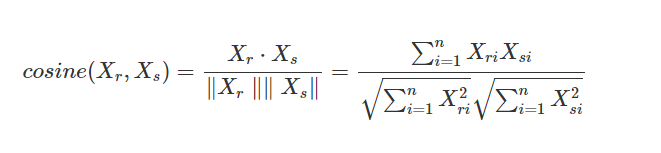

코사인 유사도는 벡터의 크기가 아닌 방향에 대해서만 유사한 정도를 측정하는 목적으로 사용한다. 차원이 많아도 손쉽게 유사도를 계산할 수 있다는 장점 때문에 많은 분야에서 활용된다. 따라서 해당 CF에서도 차원이 많지만 손쉽게 할 수 있기에 코사인 유사도를 사용해주었다. 

https://hasu.tistory.com/20

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
anime_sim = cosine_similarity(df_scaled, df_scaled)
print(anime_sim.shape)

(3069, 3069)


In [ ]:
anime_sim = pd.DataFrame(anime_sim, index = df_scaled.index, columns = df_scaled.index)

몇가지 애니메이션들의 제목을 입력해보면서 어떤 유사점이 있는지 파악해보았다. 협업필터링의 경우 비지도 학습으로 해당 모델의 성능을 평가할 수 있는 metric이 따로 없기 때문에, 분석가가 해석을 할때 다른 item인데 높은 similarity가 나온다면 해당 모델이 잘못 구성된 것으로 파악할 수 있다. 

하지만 아래의 결과를 종합적으로 분석해본 결과 유사한 애니메이션을 추천해주므로 해당 모델이 적절히 구성됨을 확인할 수 있었다. 

In [ ]:
anime_sim['Haikyuu!!'].sort_values(ascending=False)[:10]

name
Haikyuu!!                                                    1.000000
Haikyuu!! Second Season                                      0.565184
Haikyuu!!: Karasuno Koukou VS Shiratorizawa Gakuen Koukou    0.313548
Kuroko no Basket 2nd Season                                  0.255204
Kuroko no Basket 3rd Season                                  0.231307
Barakamon                                                    0.227004
Kuroko no Basket                                             0.209339
Shokugeki no Souma                                           0.208175
Hunter x Hunter (2011)                                       0.204603
One Punch Man                                                0.202245
Name: Haikyuu!!, dtype: float64

Haikyuu!!는 스포츠, 고등학생, 성장을 기반으로 하는 애니메이션이다. Haikyuu!!와 유사한 애니메이션 추천을 받았을시 동일한 Haikyuu!!: 1을 제외하고 Haikyuu!! 시즌2, Haikyuu!!: Karasuno Koukou VS Shiratorizawa Gakuen Koukou 등의 다른 시즌이 각 0.5651과 0.3135라는 코사인 유사도로 추천해주었다. 이어지는 내용의 다른 시즌이다보니 추천해준 것으로 보인다. 

그외에도 농구 기반의 고등학생 성장물인 쿠로코의 농구 시즌1,2,3과 바라카몬, 식극의 소마, 원펀치맨, 헌터헌터 등 청소년의 성장을 담고 있는 유사한 애니메이션을 추천해주었다. 

일반적으로 코사인 유사도에서는 0.5를 넘을 때 어느 정도 유사도가 있다고 이야기를 하지만 해당 CF에서는 0.5를 넘지 않아도 CF를 통해서 추천해준 애니메이션들이 일정 부분 유사도가 있는 것으로 확인되어 순위를 중심으로 분석을 하였다. 

In [ ]:
anime_sim['Naruto'].sort_values(ascending=False)[:10]

name
Naruto                     1.000000
Bleach                     0.117322
Dragon Ball GT             0.065411
Dragon Ball Z              0.058663
Fairy Tail                 0.057457
Dragon Ball                0.052570
InuYasha                   0.052372
Pokemon                    0.047623
Shaman King                0.044931
Yu☆Gi☆Oh! Duel Monsters    0.042738
Name: Naruto, dtype: float64

나루토 역시 액션, 청소년 성장물이라고 할 수 있는데 코사인 유사도는 낮지만 비슷한 스토리를 지닌 애니메이션들을 다음과 같은 순위로 추천해주었다: 블리치, 드래곤볼, 페어리테일, 이누야샤, 포켓몬, 유희왕. 청소년, 액션, 성장물이며 다음 애니메이션 들이 유사한 스토리라인과 비슷한 시기에 방영되어 꾸준히 비교되어 왔다는 점에서 괜찮은 CF 추천기능을 보여준다. 

In [ ]:
anime_sim['Dragon Ball'].sort_values(ascending=False)[:10]

name
Dragon Ball                                1.000000
Dragon Ball Z                              0.397930
Dragon Ball Kai                            0.110825
Dragon Ball GT                             0.091942
Yuu☆Yuu☆Hakusho                            0.087538
Saint Seiya                                0.074724
Rurouni Kenshin: Meiji Kenkaku Romantan    0.064708
Hajime no Ippo                             0.059836
Digimon Adventure                          0.054946
Naruto                                     0.052570
Name: Dragon Ball, dtype: float64

드래곤볼 역시 액션 성장물로 볼 수 있는데 드래곤볼 다른 시즌들을 높은 순위로 추천해주었고 비슷한 시기에 유사한 내용의 유유백서, 세인트 세이야 등을 추천해주었다는 점에서 괜찮은 CF 추천 기능을 보여준다.

나루토 역시 드래곤볼에서 마지막으로 추천해주는데 나루토의 경우 2000년대 초반 인기를 끌었던 애니메이션들이 우선 순위로 추천되었고 드래곤 볼의 경우에는 1990년대 애니메이션들이 우선 순위로 추천되었다는 점에서 비슷한 스토리나 유형의 애니메이션이라도 방영된 시기가 유저들의 평점과 애니메이션 사이 유사도에 영향을 미친다는 것을 알 수 있다. 




In [ ]:
anime_sim['Pokemon'].sort_values(ascending=False)[:10]

name
Pokemon                        1.000000
Pokemon Advanced Generation    0.291214
Yu☆Gi☆Oh! Duel Monsters        0.138370
Digimon Adventure              0.132153
Pokemon Diamond &amp; Pearl    0.128834
Digimon Adventure 02           0.116708
Yu☆Gi☆Oh!                      0.109902
Bakuten Shoot Beyblade         0.100643
Dragon Ball GT                 0.099129
Pokemon Housoukyoku            0.075419
Name: Pokemon, dtype: float64

포켓몬의 경우에도 같은 포켓몬 시리즈이거나 

- 비슷한 시기에 방영했고 
- 청소년이 성장하는 스토리이며 
- 포켓몬, 디지몬, 유희왕 카드 캐릭터와 같이 가상의 생물과 함께 성장한다는 

유사한 애니메이션들을 추천해주었다. 

In [ ]:
anime_sim['Uta no☆Prince-sama♪ Maji Love 2000%'].sort_values(ascending=False)[:10]

name
Uta no☆Prince-sama♪ Maji Love 2000%          1.000000
Uta no☆Prince-sama♪ Maji Love 1000%          0.466198
Uta no☆Prince-sama♪ Maji Love Revolutions    0.202427
Brothers Conflict                            0.147483
Kamigami no Asobi                            0.127944
Diabolik Lovers                              0.082126
2020 Nyeon Ujuui Wonder Kiddy                0.077350
Amnesia                                      0.077339
Makai Ouji: Devils and Realist               0.065901
DRAMAtical Murder                            0.063051
Name: Uta no☆Prince-sama♪ Maji Love 2000%, dtype: float64

노래의 왕자님은 아이돌 성장, 로맨스 관련 애니메이션으로 여성들의 취향을 반영한 애니메이션이다. 따라서 해당 애니메이션과 관련된 추천을 받은 결과 브라더스 컨플릭트, 카미가미노 아소비와 같이 남성 꽃미남 캐릭터들이 많이 나오는 애니메이션을 추천해준다. 따라서 유사한 애니메이션을 추천해주는 것을 알 수 있다. 

## SVD

코사인 유사도를 활용한 아이템기반의 협업필터링을 통해서도 분석을 통해 유사한 아이템들을 추천받을 수 있었다. 하지만 코사인 유사도가 낮아서 matrix factorization method, SVD를 활용한 추가적인 연구를 진행해주었다. 

복잡한 문제를 행렬로 바꾸어 행렬문제를 풀고 다시 그 행렬을 처음 문제의 상황에 적용하여 해석하는 경험을 자주 한다. 그러나 행렬계산에 있어서 가장 큰 문제는 행렬의 크기가 커짐에 따라 곱셈 등 여러 가지 경우에 그 계산이 복잡하여 컴퓨터를 이용하더라도 효율성에 대한 문제가 제기된다. 이에 주어진 행렬을 좀더 간단하고 다루기 쉬운 행렬들로 분해하면 계산에 있어서 속도와 효율성을 높일 수 있다. 또한 주어진 행렬을 여러 가지 방법으로 분해했을 때, 각각의 분해된 행렬들의 성질을 연구하여 처음 행렬의 정보를 크게 변화시키지 않으면서도 계산 속도와 크기를 조절하여 원래 의도했던 해를 구하는 것과 또 그 과정에서 얻어지는 수학적 이론은 그 이외의 문제의 해결에도 이용할 수 있다. 따라서 SVD를 사용하여 대용량의 자료를 처리하는데 빠른 속도를 보이며 자료의 손실이 발생할 수 있으나 영향이 크지 않다면 효율성을 높일 수 있다. 

http://matrix.skku.ac.kr/sglee/03-Note/IP/ImageProcessing.htm

SVD와 관련된 실습코드는 아래 사이트를 참고하였다.

https://github.com/lsjsj92/recommender_system_with_Python/blob/master/004.%20recommender%20system%20basic%20with%20Python%20-%203%20Matrix%20Factorization.ipynb

위에서 전처리된 데이터를 사용하여 SVD를 활용한 협업필터링을 진행했다. 
SVD 특이값 분해란 m x n 크기의 데이터 행렬 A를 아래와 같이 분해하는 것을 말한다.


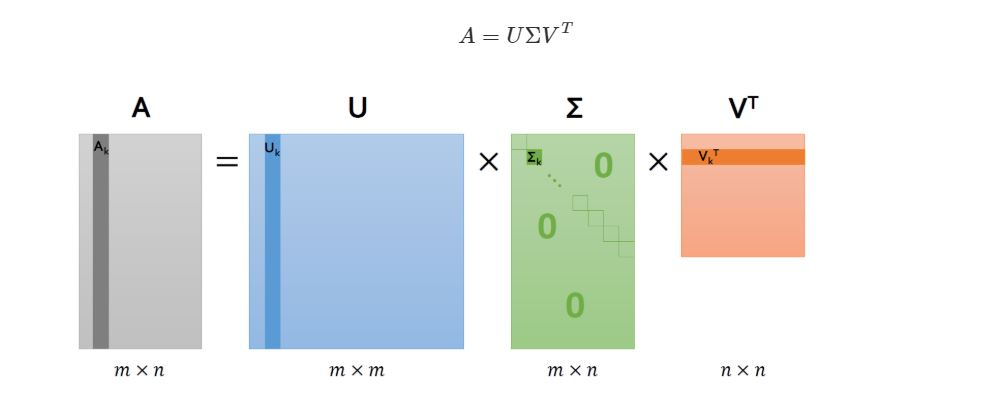

In [ ]:
from sklearn.decomposition import TruncatedSVD
from scipy.sparse.linalg import svds

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [ ]:
df = df.fillna(0)

In [ ]:
df.head()

name,.hack//Roots,.hack//Sign,.hack//Tasogare no Udewa Densetsu,009-1,07-Ghost,11eyes,12-sai.: Chicchana Mune no Tokimeki,12-sai.: Chicchana Mune no Tokimeki 2nd Season,2020 Nyeon Ujuui Wonder Kiddy,21 Emon,...,"Zone of the Enders: Dolores, I",Zukkoke Knight: Don De La Mancha,ef: A Tale of Melodies.,ef: A Tale of Memories.,gdgd Fairies,gdgd Fairies 2,iDOLM@STER Xenoglossia,s.CRY.ed,xxxHOLiC,xxxHOLiC Kei
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
anime_user_rating = df.values.T
anime_user_rating.shape

(3069, 68929)

In [ ]:
type(anime_user_rating)

numpy.ndarray

In [ ]:
SVD = TruncatedSVD(n_components=12)
matrix = SVD.fit_transform(anime_user_rating)
matrix.shape

(3069, 12)

12개의 component로 차원을 축소해주었다. 나온 데이터를 활용하여 피어슨 상관계수를 구해주었다. 코사인 유사도의 경우 특정 인물의 점수기준이 극단적으로 너무 낮거나 높을 경우 유사도에 영향을 크게 준다 따라서 이를 막기 위해 상관계수를 사용한다. 

In [ ]:
matrix[0]

array([ 68.62442381,  58.47441048, -22.53632401,   9.32331033,
       -15.70927017, -39.62257451,  -2.80692308, -17.56454838,
         5.19596622,  13.90493946, -21.57364298, -24.82609857])

In [ ]:
corr = np.corrcoef(matrix)
corr.shape

(3069, 3069)

In [ ]:
corr2 = corr[:200, :200]
corr2.shape

(200, 200)

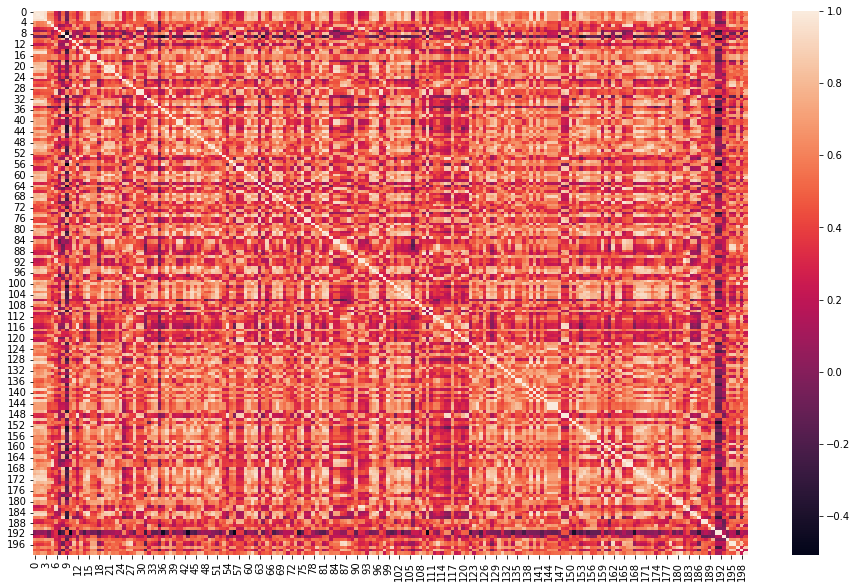

In [ ]:
plt.figure(figsize=(16, 10))
sns.heatmap(corr2)

나온 상관계수를 이용해서 특정 애니메이션과 상관계수가 높은 (계수 0.9 이상) 애니메이션을 뽑아준다. 

In [ ]:
anime_title = df.columns
anime_title_list = list(anime_title)
coffey_hands = anime_title_list.index("Dragon Ball")
corr_coffey_hands  = corr[coffey_hands]
list(anime_title[(corr_coffey_hands >= 0.9)])[:50]

['Bakuten Shoot Beyblade',
 'Bakuten Shoot Beyblade 2002',
 'Bobobo-bo Bo-bobo',
 'Captain Tsubasa',
 'Captain Tsubasa J',
 'Digimon Adventure',
 'Dragon Ball',
 'Dragon Ball GT',
 'Dragon Ball Kai',
 'Dragon Ball Z',
 'Duel Masters',
 'Ganbare! Kickers',
 'God Mazinger',
 'Jibaku-kun',
 'Kenyuu Densetsu Yaiba',
 'Kinnikuman',
 'Kinnikuman II Sei',
 'Kinnikuman II Sei: Ultimate Muscle',
 'Kinnikuman II Sei: Ultimate Muscle 2',
 'Kochira Katsushikaku Kameari Kouenmae Hashutsujo (TV)',
 'Konjiki no Gash Bell!!',
 'Mach GoGoGo (1997)',
 'Mazinger Z',
 'Medarot',
 'Medarot Damashii',
 'Mega Man',
 'Monster Farm: Enbanseki no Himitsu',
 'Monster Farm: Legend e no Michi',
 'Pokemon',
 'Saint Seiya',
 'Seigi wo Aisuru Mono Gekkou Kamen',
 'Street Fighter II V',
 'Tenkuu Senki Shurato',
 'Transformers Headmasters',
 'Viewtiful Joe',
 'Yuu☆Yuu☆Hakusho',
 'Yu☆Gi☆Oh!',
 'Yu☆Gi☆Oh! Duel Monsters',
 'Zoids']

드래곤볼의 경우 액션 성장물로 볼 수 있는데 드래곤볼 다른 시즌들을 높은 순위로 추천해주었고 비슷한 시기에 유사한 내용의 (코사인 유사도에서도 추천해주었던) 유유백서, 세인트 세이야 등을 추천해주었다는 점에서 괜찮은 CF 추천 기능을 보여준다.

SVD 역시 비슷한 시기 1990년대 애니메이션들을 추천해주어 애니메이션 스토리 유사도 뿐만 아니라 비슷한 시기에 인기 있었던 애니메이션들이 서로 비슷한 평점을 받고 유사도가 있음이 확인 되었다. 

In [ ]:
anime_title = df.columns
anime_title_list = list(anime_title)
coffey_hands = anime_title_list.index("Haikyuu!!")
corr_coffey_hands  = corr[coffey_hands]
list(anime_title[(corr_coffey_hands >= 0.9)])[:50]

['Barakamon',
 'Diamond no Ace',
 'Haikyuu!!',
 'Haikyuu!! Second Season',
 'Kuroko no Basket',
 'Kuroko no Basket 2nd Season',
 'Kuroko no Basket 3rd Season',
 'Yowamushi Pedal',
 'Yowamushi Pedal: Grande Road']

Haikyuu!!는 스포츠, 고등학생, 성장을 기반으로 하는 애니메이션이다. Haikyuu!!와 유사한 애니메이션 추천을 받았을시 동일한 Haikyuu!!: 1을 제외하고 Haikyuu!! 시즌2 다른 시즌을 추천해주었다. 이어지는 내용의 다른 시즌이다보니 추천해준 것으로 보인다. 

그외에도 농구 기반의 고등학생 성장물인 쿠로코의 농구 시즌1,2,3과 바라카몬, 식극의 소마, 겁쟁이 페달 등 청소년의 성장과 운동관련 내용의 유사한 애니메이션을 추천해주었다. 

종합적으로 코사인 유사도를 사용한 결과와 SVD를 사용한 결과가 비슷한 것으로 보여 적절한 CF가 진행되었음을 확인할 수 있었다. 추가적으로 비슷한 시기에 방영되는 애니메이션들을 추천해준다는 점에서 사용자들이 애니메이션 평점에 있어서 애니메이션 방영 시기가 영향이 있다는 것을 확인할 수 있었다. 